Task-3: Implement a support vector machine (SVM) to classify images of cats and dogs from the Kaggle dataset.

Step 1: Load Libraries

In [1]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

Step 2: Dataset Overview / EDA

In [2]:
DATADIR = r"C:\Users\Shagufta Umme\Desktop\Task 3\PetImages"
CATEGORIES = ["Cat", "Dog"]


In [3]:
# Count images
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    print(f"Number of {category}: {len(os.listdir(path))}")

Number of Cat: 12499
Number of Dog: 12499


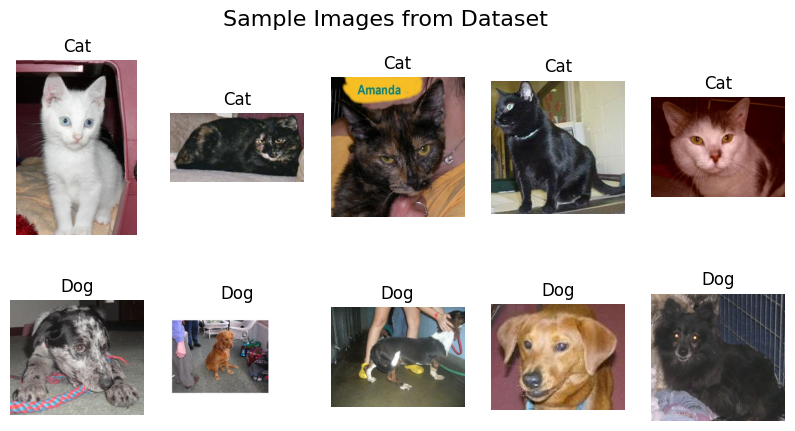

In [4]:
# Display 5 random images per class
plt.figure(figsize=(10,5))
for i, category in enumerate(CATEGORIES):
    path = os.path.join(DATADIR, category)
    images = os.listdir(path)
    for j in range(5):
        img_name = random.choice(images)
        img = cv2.imread(os.path.join(path, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2,5,i*5 + j + 1)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')
plt.suptitle("Sample Images from Dataset", fontsize=16)
plt.show()

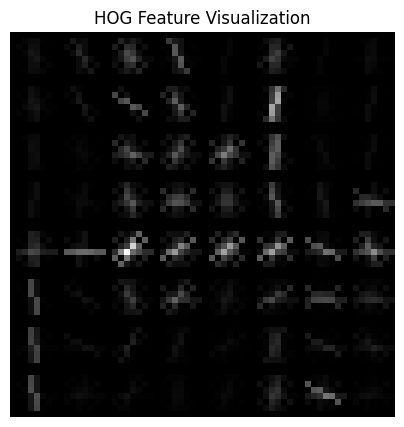

In [5]:
# Optional: HOG visualization for one sample image
sample_img_path = os.path.join(DATADIR, "Cat", os.listdir(os.path.join(DATADIR, "Cat"))[0])
gray_img = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)
gray_img = cv2.resize(gray_img, (64,64))

features, hog_image = hog(gray_img, orientations=9, pixels_per_cell=(8,8),
                          cells_per_block=(2,2), visualize=True, block_norm="L2-Hys")

plt.figure(figsize=(5,5))
plt.imshow(hog_image, cmap='gray')
plt.title("HOG Feature Visualization")
plt.axis('off')
plt.show()

Step 3: Feature Extraction (HOG + Color Histogram)

In [6]:
limit_per_class = 2000  # Adjust based on your laptop capacity
data = []
labels = []
original_images = []

def extract_features(img_path, img_size=64):
    """Combine HOG + color histogram features"""
    gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    gray = cv2.resize(gray, (img_size, img_size))
    hog_feat = hog(gray, orientations=9, pixels_per_cell=(8,8),
                   cells_per_block=(2,2), visualize=False, block_norm="L2-Hys")
    
    color = cv2.imread(img_path)
    color = cv2.resize(color, (img_size, img_size))
    hist_b = cv2.calcHist([color],[0],None,[16],[0,256]).flatten()
    hist_g = cv2.calcHist([color],[1],None,[16],[0,256]).flatten()
    hist_r = cv2.calcHist([color],[2],None,[16],[0,256]).flatten()
    
    features = np.concatenate([hog_feat, hist_b, hist_g, hist_r])
    return features

In [7]:
# Loop through categories
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    class_num = CATEGORIES.index(category)
    files = os.listdir(path)[:limit_per_class]
    
    for img_name in files:
        try:
            img_path = os.path.join(path, img_name)
            features = extract_features(img_path)
            data.append(features)
            labels.append(class_num)
            
            orig_img = cv2.imread(img_path)
            original_images.append(orig_img)
        except Exception as e:
            pass

X = np.array(data)
y = np.array(labels)

print(f"Total images used: {len(original_images)}, Feature vector shape: {X.shape}")


Total images used: 3999, Feature vector shape: (3999, 1812)


Step 4: Train-Test Split & Scaling

In [8]:
X_train, X_test, y_train, y_test, train_images, test_images = train_test_split(X, y, original_images, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Step 5: Train SVM with Hyperparameter Tuning

In [9]:
param_grid = {
    'C': [1, 10, 50],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, cv=3, verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

svm_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


Step 6: Evaluate Model

In [10]:
y_pred = svm_model.predict(X_test)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=CATEGORIES))

✅ Accuracy: 0.7625

Classification Report:
               precision    recall  f1-score   support

         Cat       0.78      0.73      0.75       400
         Dog       0.75      0.80      0.77       400

    accuracy                           0.76       800
   macro avg       0.76      0.76      0.76       800
weighted avg       0.76      0.76      0.76       800



Step 7: Predict Two Random Test Images

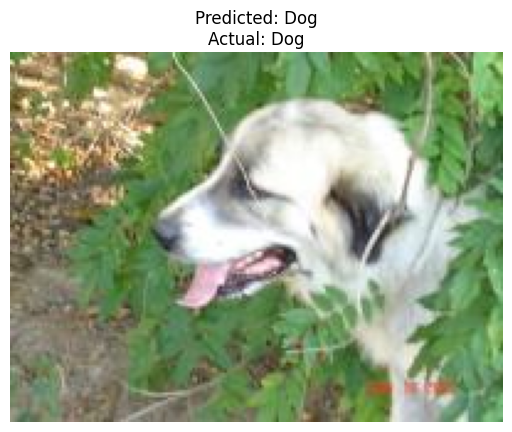

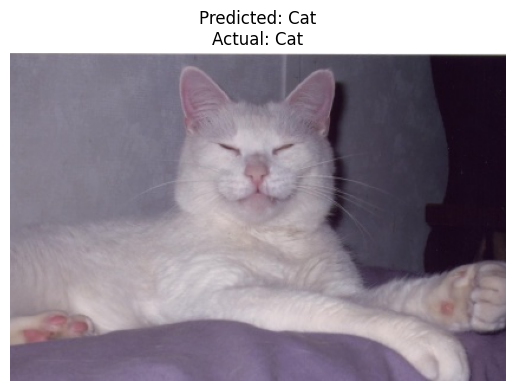

In [11]:
random_indices = random.sample(range(len(X_test)), 2)

for idx in random_indices:
    img = test_images[idx]
    features = X_test[idx].reshape(1, -1)
    pred_label = svm_model.predict(features)[0]
    actual_label = y_test[idx]
    
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {CATEGORIES[pred_label]}\nActual: {CATEGORIES[actual_label]}")
    plt.axis("off")
    plt.show()


Step 8: Predict External Image by Path

Prediction: Cat


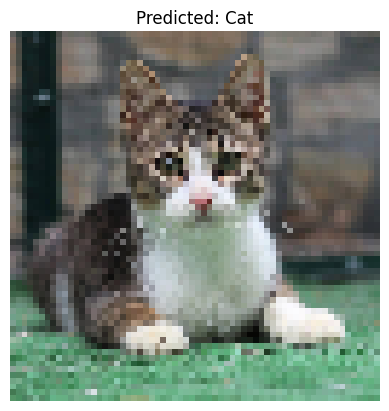

In [12]:
def prepare_image(path, img_size=64):
    gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    gray = cv2.resize(gray, (img_size, img_size))
    hog_feat = hog(gray, orientations=9, pixels_per_cell=(8,8),
                   cells_per_block=(2,2), visualize=False, block_norm="L2-Hys")
    
    color = cv2.imread(path)
    color = cv2.resize(color, (img_size, img_size))
    hist_b = cv2.calcHist([color],[0],None,[16],[0,256]).flatten()
    hist_g = cv2.calcHist([color],[1],None,[16],[0,256]).flatten()
    hist_r = cv2.calcHist([color],[2],None,[16],[0,256]).flatten()
    
    features = np.concatenate([hog_feat, hist_b, hist_g, hist_r])
    features = scaler.transform([features])
    return color, features

external_image_path = r"C:\Users\Shagufta Umme\Downloads\image for prediction.jpg"  # replace with your image path
img, img_features = prepare_image(external_image_path)
prediction = svm_model.predict(img_features)[0]
print("Prediction:", CATEGORIES[prediction])

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {CATEGORIES[prediction]}")
plt.axis("off")
plt.show()